##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Click the button on top that says, `Open in Colab`, to run this notebook as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

In [4]:
import os

from tensorflow.keras import layers #keras layers API, to pick at the layers, 
                                    #and to understand which ones we want to use, and which ones we want to retrain.
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5      # this link containes,like snapshot of the model after being trained. 
  


--2021-12-25 14:05:56--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   170MB/s    in 0.5s    

2021-12-25 14:05:57 (170 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 #keras has the model definition built

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, # inception V3 has a fully-connected layer at the top so by setting include_top to false, 
                                                     #you're specifying that you want to ignore this and get straight to the convolutions. 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
#we can iterate through its layers and lock them, saying that they're not(False) going to be trainable with this code. 
for layer in pre_trained_model.layers:
  layer.trainable = False
  
  #pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7') #All of the layers have names, so you can look up the name of the last layer that you want to use.
                                                   # mixed7, which is the output of a lot of convolution that are 7 by 7.
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
# should look exactly like the dense models that we created way back
# The code is a little different, but this is just a different way of using the layers API.
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)  # dropping out 20% of our neurons                

# Add a final output sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

#Model abstract class. And passing at the input and the layers definition that you've just created.
model = Model( pre_trained_model.input, x) 

#combile with a optimazer, loss function and result matrics you want to collect
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [7]:
# will download the abbreviated version of cats versus dogs,
#unzip it into training and validation directories, 
#and then set up the image generators.
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 83.6MB/s]
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 36s - loss: 0.3472 - accuracy: 0.8660 - val_loss: 0.2273 - val_accuracy: 0.9200 - 36s/epoch - 365ms/step
Epoch 2/20
100/100 - 32s - loss: 0.2344 - accuracy: 0.9070 - val_loss: 0.1255 - val_accuracy: 0.9560 - 32s/epoch - 324ms/step
Epoch 3/20
100/100 - 23s - loss: 0.1947 - accuracy: 0.9280 - val_loss: 0.1071 - val_accuracy: 0.9650 - 23s/epoch - 230ms/step
Epoch 4/20
100/100 - 22s - loss: 0.2016 - accuracy: 0.9265 - val_loss: 0.1168 - val_accuracy: 0.9620 - 22s/epoch - 224ms/step
Epoch 5/20
100/100 - 24s - loss: 0.1956 - accuracy: 0.9290 - val_loss: 0.1039 - val_accuracy: 0.9660 - 24s/epoch - 240ms/step
Epoch 6/20
100/100 - 22s - loss: 0.1720 - accuracy: 0.9380 - val_loss: 0.1366 - val_accuracy: 0.9560 - 22s/epoch - 225ms/step
Epoch 7/20
100/100 - 22s - loss: 0.1481 - accuracy: 0.9460 - val_loss: 0.1222 - val_accuracy: 0.9680 - 22s/epoch - 220ms/step
Epoch 8/20
100/100 - 22s - loss: 0.1956 - accuracy: 0.9325 - val_loss: 0.1215 - val_accuracy: 0.9610 - 22s/epoch - 223

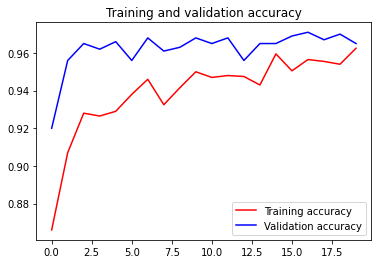

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()
#the training accuracy is around 90 percent, and the validation is close to 97 percent. That's in pretty good shape. 
#So let's plot the 20 epochs and we can see that the curves are in sync. This is a good sign that we're avoiding overfitting. 